# TN3155 Lecture 9: Introduction to QuTiP

In this lecture, we will cover a basic introduction to QuTiP that you will need for your final project. 

Here, I hope to explain most of the things you need. However, I am sure that there will be things that your will need or want to do that may not be covered here. Fortuantely, there is quite a lot of information available on the QuTiP website. A good starting point is the documentation: 

http://qutip.org/docs/latest/index.html

Also, there are many tutorials online, in particular the "Lectures" at the bottom of the page cover things as a relatively simple starting point:

http://qutip.org/tutorials.html

## Background and information for this notebook 

### Learning objectives

The following is a list of things you should be able to do after mastering this material:

Basics:

* Start up and create a jupyter notebook using QuTiP from scratch
* Create quantum objects in qutip

Creating states and operators:

* Create states of the harmonic oscillator (HO) using `fock()`, `coherent()`, and similar functions
* Create coherent and squeezed states by displacing and squeeze the HO ground state
* Create and use HO opeartors, such as $\hat x$, $\hat n$, $\hat a$, $\hat a^\dagger$
* Create spin-1/2 states using `basis()`
* Create spin-1/2 operators using `sigmax()`, `sigmay()`, etc
* Create density matrices of pure states and mixed statets
* Create projection operators for the eigenstates of an observable 

Calculating things:

* Calculate expectation values of operators using states and "series" of states using `expect()`
* Calculating the time dependence of a state using the Lindblad master equation with `mesolve()`
* Calculating the time dependence of states and individual quantum trajectories using `mcsolve()`

Plotting things:

* Generate plots of Wigner functions using `plot_wigner()`
* Generate basic plots of expectation values vs time using matplotlib
* Generate 3D plots of states on a Block sphere using `Bloch()`

### Previous notebooks

Many of the above topics have already been covered in previous notebooks:

* TN3155 Lecture 5 Python
* TN3155 Lecture 7 Python
* TN3155 Lecture 8 Python
* Homework Lecture 8 Solutions Python

Please download these, have a look at the code, play around with it, and ask any questions if you are not sure how it works. 

### Importing libraries

As you have seen in previous notebooks, the first step is to import the libraries we will need. In general, this list should do:

In [11]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

### New topics for today

In addition to what has already been demonstrated in previous notebooks, the following sections contain additional topics you may use in your project.

## Eigenstates of an operator

In QuTiP, all operator objects have a built-in function called `eigenstates()` that returns the eigenstates and eigenvalues of an operator:

http://qutip.org/docs/latest/apidoc/classes.html#qutip.Qobj.eigenstates

As an example below, we will take a look at how the eigenstates of the $\hat x$ operator look like in a truncated Hilbert space. 

We know that the eigenstates of $\hat x$ are [Dirac Delta functions](https://en.wikipedia.org/wiki/Dirac_delta_function). This is clear when we work in a Hilbert space basis based on position such that our quantum states are represented by wave functions $\psi(x)$. 

But what if we work in a (truncated) Hilbert space of Harmonic oscillator eigenstates ("Fock states")? What does the column vector look like for the eigenstates of the $\hat x$ operator in a Fock basis? (Particularly a truncated one?)

It's not very obvious to me, but we can easily use QuTiP to check. 

In [ ]:
# The size of our Hilbert space
N = 50

# The annihilation operator
a = destroy(N)

# Handy: opeators objects have a built-in function that returns their Hermitian conjugate 
x = a + a.dag()

# And they have a function that returns their eigenvalues and eigenstates (assuming they are Hermitian)
eigvals, eigstates = x.eigenstates()

What are `eigvals` and `eigstates`? We can check this using the python `type()` function:

In [ ]:
print(type(eigvals))
print(type(eigstates))
print(len(eigvals))
print(len(eigstates))
print(eigvals.shape)
print(eigstates.shape)

They are both "numpy arrays" with 50 entries, which makes sense since our Hilbert space has dimension 50. By looking at their shape, we can see that they are 1D arrays.   We can check what's in them by looking, for example, at the first entries:

In [ ]:
eigvals[0]

As we expect, eigvals are clearly numerical values, which should represent the eigenvalues of the $\hat x` operator, and which should span the biggest distances we can achieve in position in our 50 Fock-state Hilbert space. 

We can check by plotting them:

In [ ]:
plt.plot(eigvals)
plt.xlabel("Eigenstate number")
plt.ylabel("Eigenvalue (= 'position x')")
plt.title("Eigenvalues of the $\hat x$ operator")

They are approximately linearly space and run from -13 to 13. In what units? This is qutip with $\hbar = 1$, so this should be something like distance measured zero point fluctuations. (We can check that later.) 

We notice that at the ends that they deviate from a straight line: as one might guess, this likely has something to do with the truncation of the Hilbert space (which we will see in more detail in a minute). 

Let's look at the eigenstates:

In [ ]:
eigstates[25]

OK, interesting. Let try plotting it's Wigner function:

In [ ]:
plot_wigner(eigstates[25], alpha_max = 12)

Note that I have used the `alpha_max` parameter to set what the limits of the plot are in x-p ("phase") space. 

This looks about right: it is sharp peak that is delocalized in momentum. You can see the limitation of the Hilbert space size though: 

* It is not infinitely sharp
* It is not perfectly flat in momentum (as one would expect for the Fourier transform of a delta function)
* It has some "fringes" around it

We can take a look at all of them using the `ipywidgets` library to make an interactive plot with a slider:

In [ ]:
from ipywidgets import interact 

def update(i):
    plot_wigner(eigstates[i],alpha_max = 12)

interact(update, i=(0,len(eigstates)-1));

We can also see that things get worse at the edges, which makes sense!

**Exercise 1:** Make an interactive plot for plotting the Wigner functions of the $\hat p$ operator. 

In [ ]:
# Your code here

## Change bases and calculating arbitrary probability distributions

In the the lecture notes on Wigner functions, I included some code for plotting a function proportional to the probability distributions $|\psi(x)|^2$ and $|\phi()|^2. These were useful for the plots, but since I used a sum and not an integral, they were not normalized properly. 

What is the proper way of calculating these? What we should really do is perform a basis transformation of our quantum states to a position basis, such as the one we calculated above, and then take the square magnitude of our column vector. 

Sounds tricky...but fortunately, QuTiP has functions built in for this! In fact, each quantum object contains a function `transform()` that returns that object transformed to a new basis: 

http://qutip.org/docs/latest/apidoc/classes.html#qutip.Qobj.transform

Let's take a look. 

We'll start with say the ground state of the Harmonic oscillator. In a Fock basis, this is just a column vector with one 1 and all the rest zeros:

In [ ]:
psi = fock(N,0)
psi

We can make a plot of it's entries using this command:

In [ ]:
plt.plot(np.abs(psi.full())**2, 'o-')
plt.xlabel("Fock number")
plt.ylabel("Probability")

The function `full()` in quantum objects returns the non-sparse version of the object, which you will need for plotting. 

Now let's try a basis transformation:

In [ ]:
x = a + a.dag()
x_vals, x_states = x.eigenstates()
psi_x = psi.transform(x_states)
psi_x

And now let's try plotting $|\psi(x)|^2$:

In [ ]:
plt.plot(x_vals, np.abs(psi_x)**2, '.-')
plt.ylabel(r"$|\psi(x)|^2$")
plt.xlabel("x")

It looks reasonable! We can now also see the units are probably not $x_{zpf}$, since the FWHM of the ground state probability distribution should be $2.35 \sigma$ with $ \sigma = x_{zpf}$. This is probably due to the different convention for the definition of $\alpha$ used in QuTiP (it is different by a factor $\sqrt{2}$, as mentioned in class...and as I discovered making the notes for Lecture 5...) 

**Exercise 2:** Calculate $|\psi(x)|^2$ and $|\phi(p)|^2$ for a Schroedinger cat state $\frac{1}{\sqrt{2}}\left(\left|\alpha \right\rangle + \left|-\alpha \right\rangle\right)$. 

## QuTiP Monte Carlo Solver

As mentioned in class, an equivalent way of understanding the Lindblad equation is as an average of an ensemble of "quantum trajectories" which contain a stochastic set of collapse events with stochastic outcomes. 

The `mcsolve` routine in QuTiP is a routine that solves for quantum evolution during measurement in precisely such a way:  

http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.mcsolve

Let's take a look at an example, and specifically, the example from the homework of the decaying spin superposition state. This was the code with the Lindblad master equation using `mesolve():`

In [3]:
N = 2

psi0 = basis(N,0) + basis(N,1)
psi0 = psi0.unit()

w = 1 * 2 * np.pi 
H = 0.5 * w * sigmaz()

gamma = 0.1 * w
c_ops = [np.sqrt(gamma) * sigmam()]

t = np.linspace(0, 10, 201) 
result_me = mesolve(H, psi0, t, c_ops)

And this is what we got as a result:

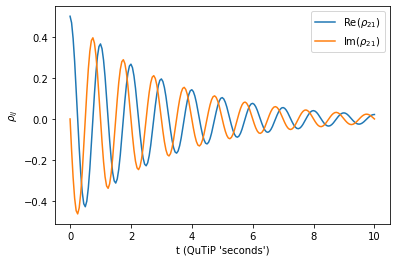

In [4]:
plt.plot(t,np.real(expect(result_me.states, projection(2,1,0))), label=r'Re($\rho_{21}$)');
plt.plot(t,np.imag(expect(result_me.states, projection(2,1,0))), label=r'Im($\rho_{21}$)');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (QuTiP 'seconds')")
plt.legend()
plt.show()

Note that the states that `mesolve` returns are density matrices, which makes sense. This will show us the state calculated at the first time step:

In [6]:
result_me.states[0]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

To solve this with the Monte Carlo solver, we simply use nearly the same function call:

In [7]:
result_mc1 = mcsolve(H, psi0, t, c_ops)

10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.27s. Est. time left: 00:00:00:01
30.0%. Run time:   0.37s. Est. time left: 00:00:00:00
40.0%. Run time:   0.47s. Est. time left: 00:00:00:00
50.0%. Run time:   0.57s. Est. time left: 00:00:00:00
60.0%. Run time:   0.67s. Est. time left: 00:00:00:00
70.0%. Run time:   0.78s. Est. time left: 00:00:00:00
80.0%. Run time:   0.88s. Est. time left: 00:00:00:00
90.0%. Run time:   0.98s. Est. time left: 00:00:00:00
100.0%. Run time:   1.11s. Est. time left: 00:00:00:00
Total run time:   1.16s


In the way it is used above, the result object `mcsolve()` returns will no contain a density matrix for each time step, but instead a list of wavefunctions (`kets`) corresponding to each member of the ensemble:

In [8]:
result_mc1.states.shape

(500, 201)

We can use an interactive slider to scroll through the ensemble:

In [12]:
def update(i=0):
    plt.plot(t, expect(sigmax(), result_mc1.states[i][:]), label="MC i = %d" % i)
    plt.plot(t, expect(sigmax(), result_me.states), label="ME")
    plt.ylabel("$<\sigma_x>$")
    plt.xlabel("Time (s)")
    plt.legend()
    
interact(update, i=(0,499));

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

This is is an interesting result for many reasons. 

First, the blue lines do not quite just do what the usual Schroedinger equation do: with no measurement, the oscillations of $\sigma_x$ would stay constant. In the blue curve, they linearly decrease. 

Why? This is because the measurement operator $\sigma_-$ is not Hermitian and not unitary: even with no collapse events, it will still decrease the energy of the system and change the normalisation. This is in fact what the Monte Carlo wave function method does when the collapse operator is not unitary. For more reading on this, this is a very good article I enjoyed reading very much: 

https://doi.org/10.1364/JOSAB.10.00052

The second thing to note: even though the blue curve is decreasing in amplitude, it is not doing so as fast as the orange one. If you use the slider to take a look at a few of the different quantum trajectories, you will see why: sometimes, there is a collapse event and the oscillations jump to zero and stop!

Now, if we average over all of these quantum jumps, we should recover the master equation result. We can do this most easily in QuTiP by giving `mcsolve` a list of expectation values we would like it to calculate: 

In [13]:
result_mc2 = mcsolve(H, psi0, t, c_ops, e_ops = [sigmax()])

10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.28s. Est. time left: 00:00:00:01
30.0%. Run time:   0.41s. Est. time left: 00:00:00:00
40.0%. Run time:   0.79s. Est. time left: 00:00:00:01
50.0%. Run time:   0.91s. Est. time left: 00:00:00:00
60.0%. Run time:   1.04s. Est. time left: 00:00:00:00
70.0%. Run time:   1.15s. Est. time left: 00:00:00:00
80.0%. Run time:   1.27s. Est. time left: 00:00:00:00
90.0%. Run time:   1.39s. Est. time left: 00:00:00:00
100.0%. Run time:   1.51s. Est. time left: 00:00:00:00
Total run time:   1.59s


Using `mcsolve` in this way, it will not return any state vectors, but instead the expectation values as a function of time of the operators we specify in `e_ops` list:

In [14]:
len(result_mc2.expect[0][:])

201

In [15]:
plt.plot(t,result_mc2.expect[0][:], label="MC average")
plt.plot(t, expect(sigmax(), result_me.states), label="ME")
plt.ylabel("$<\sigma_x>$")
plt.xlabel("Time (s)")
plt.legend();

Averaging over all the trajectories, we now see that our Monte Carlo result converges to that predicted by the Master equation!

What is the advantage of the Monte Carlo method? 

For larger Hilbert spaces, it is faster than the master equation approach. (It is actually slower here due to the overhead of setting up the calculations...)

But it can also useful to understand what we would see if we were able to observe the result of an individual realisation of an experiment: experimentally, this means that our experiment is sensitive enough to measure with precision close to the quantum limit at a rate that is faster than the collapse events from other things measuring our object. A particularly beautiful example of this is the paper that is mentioned in the example project notebook file. 

## Time Dependent Hamiltonians and collapse operators

Until now, we have been simulating Hamiltonians that are not dependent on time, but QuTiP has full support as well for time-dependent Hamiltonians:

http://qutip.org/docs/4.3/guide/dynamics/dynamics-time.html

Here, we will look at a simple example: shaking an undamped Harmonic oscillator with an oscillating force. For a force $F = F_0 \cos(\omega t)$, we will have a time dependent additional term in the Hamiltonian given by:

$$
\hat H = (\hat a^\dagger \hat a + \tfrac{1}{2}) + F_0 \cos(\omega t) \hat x
$$

To make this work in QuTiP, we write this in the following way:

$$
\hat H = \hat H_0 + \hat H_1 f(t)
$$

where $f(t)$ is a time dependent coefficient and $H_1$ contains only time-independent operators and coefficients. For our example above, we could choose for example:

$$
\hat H_1 = F_0 \hat x
$$

and

$$
f(t) = \cos(\omega t)
$$

Once we have made these choices, we can give the operators $H_0$, and $H_1$, and the function $f(t)$ to the solver routines.

Let's try it out:

In [ ]:
N = 10
w = 1 * 2 * np.pi 
F0 = 0.5

a = destroy(N)
H0 = w * (a*a.dag() + 0.5)
x = a+a.dag()
H1 = F0 * x

# The first argument should be 't', and the second one is "args" (not sure
# what 'args' does but it needs to be there even if you don't use it...)
def f(t, args):
    return np.cos(w*t)

psi0 = fock(N,0)

# We will not include any c_ops, which means we are just
# simulating the Schroedinger equation
c_ops = [] 

t = np.linspace(0,5,100)

# For time dependent Hamiltonians, we create a list that includes first 
# H0 as the first entry, then a list as the second entry that includes 
# H1 and then the name of the function f(t)

H = [H0, [H1, f]]

result = mesolve(H, psi0, t, c_ops)

Does this do what we think it should? Let's check:

In [ ]:
plt.plot(expect(x,result.states))

That makes sense! Let's try making a Wigner animation:

In [ ]:
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['animation.embed_limit'] = 100

fig, ax = plt.subplots(1, 1, figsize=(6,6))
def update(n):
    ax.cla() # Clear axis. Without this, generating the animation takes a lot longer...
    plot_wigner(result.states[n],fig=fig,ax=ax)

anim = animation.FuncAnimation(fig, update, frames=len(result.states))
plt.close(fig)

It takes a while to generate the animation, but it's worth it!

In [ ]:
anim

The same technique can be used to generate time-dependent collapse operators to simulate, for example, a measurement whose strength is changed in time.